# Deeplabcut analysis

## Step 1: Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import umap
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Step 2: Load the Data

In [2]:
path_to_extracted_folder = 'E:/deeplabcut/'
data_files = os.listdir(path_to_extracted_folder)
saline_files = [file for file in data_files if any(mouse in file for mouse in ['322', '328', '330', '332'])]
pfa_files = [file for file in data_files if any(mouse in file for mouse in ['326', '327', '334', '335', '336'])]

saline_dataframes = [pd.read_csv('E:/deeplabcut/' + file, header=[1,2]) for file in saline_files]
pfa_dataframes = [pd.read_csv('E:/deeplabcut/' + file, header=[1,2]) for file in pfa_files]

In [7]:
saline_dataframes

[      bodyparts miniscope_head                                 snout   
          coords              x           y    likelihood           x   
 0             0     447.050446  321.363403  9.999995e-01  461.893188  \
 1             1     447.050385  321.363861  9.999995e-01  461.892944   
 2             2     447.774750  324.071869  9.999996e-01  460.488953   
 3             3     448.040405  324.306885  9.999998e-01  460.833435   
 4             4     448.622437  324.295502  9.999999e-01  462.384003   
 ...         ...            ...         ...           ...         ...   
 54465     54465     857.204041  244.275925  9.999995e-01  887.741028   
 54466     54466     857.207214  244.547256  9.999994e-01  887.591980   
 54467     54467     857.206177  244.547272  9.999994e-01  887.594604   
 54468     54468     856.949097  244.814880  9.999993e-01  888.284424   
 54469     54469       0.460701   -3.486323  1.347444e-09   -4.051118   
 
                                        head     

## Step 3: Data Cleaning

In [3]:
def clean_data(df):
    # Replace missing values or NaN with interpolation
    df.interpolate(method='linear', inplace=True, limit_direction='both')
    return df

saline_dataframes = [clean_data(df) for df in saline_dataframes]
pfa_dataframes = [clean_data(df) for df in pfa_dataframes]

In [4]:
df_led = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_led_frames.csv')

In [5]:
df_box = pd.read_csv(r'H:\DANNCE\6cam_behavior\topviewcam\top_view_cam_box_ccordinates.csv')

In [20]:
# Creating the dataframe manually using the provided data
frame_info_data = {
    "Start": [0, 1, 379, 325, 330, 297, 5705, 182, 13205, 8233, 6087, 1795, 4982, 180, 4926, 225, 10785, 1429],
    "End": [8576, 181, 54379, 54324, 54330, 54297, 59704, 54183, 67204, 62233, 60087, 55795, 58982, 54181, 58924, 54226, 64784, 55430],
    "Frames": [53998, 53999, 54000, 53999, 54000, 54000, 53999, 54001, 53999, 54000, 54000, 54000, 54000, 54001, 53998, 54001, 53999, 54001],
    "Filename": ["322", "322_sal", "326", "326_PFA", "327", "327_PFA", "328", "328_sal", "330", "330_sal", "332", "332_sal", "334", "334_PFA", "335", "335_PFA", "336", "336_PFA"]
}

frame_info_df_manual = pd.DataFrame(frame_info_data)

# Displaying the manually created dataframe
frame_info_df_manual


,Start,End,Frames,Filename
0,0,8576,53998,322
1,1,181,53999,322_sal
2,379,54379,54000,326
3,325,54324,53999,326_PFA
4,330,54330,54000,327
5,297,54297,54000,327_PFA
6,5705,59704,53999,328
7,182,54183,54001,328_sal
8,13205,67204,53999,330
9,8233,62233,54000,330_sal


In [21]:
for df, file_name in zip(dataframes, data_files):
    # Get the start frame for the current file
    start_frame = frame_info_df_manual[frame_info_df_manual['Filename'] == file_name]['Start'].values[0]
    
    # Crop the dataframe
    cropped_df = df.iloc[start_frame : start_frame + 54000]
    
    # Replace the original dataframe with the cropped version
    dataframes[dataframes.index(df)] = cropped_df


NameError: name 'dataframes' is not defined

In [9]:
# List of specified body parts
body_parts = ['head', 'leftEar', 'rightEar', 'centerofMass', 'leftHip', 'rightHip', 'tailRoot']

def compute_center_coordinates(df):
    # Extracting x and y coordinates for the specified body parts
    x_coords = df.loc[:, pd.IndexSlice[body_parts, 'x']]
    y_coords = df.loc[:, pd.IndexSlice[body_parts, 'y']]
    
    # Computing average x and y coordinates across the body parts for each frame
    df['center_x'] = x_coords.mean(axis=1)
    df['center_y'] = y_coords.mean(axis=1)
    
    return df

# Applying the function to all dataframes in both conditions
saline_dataframes = [compute_center_coordinates(df) for df in saline_dataframes]
pfa_dataframes = [compute_center_coordinates(df) for df in pfa_dataframes]

# Checking the first few rows of the first dataframe in the saline condition to verify the new columns
saline_dataframes[0].head()


bodyparts miniscope_head                              snout               
     coords              x           y likelihood           x           y   
0         0     447.050446  321.363403        1.0  461.893188  328.412292  \
1         1     447.050385  321.363861        1.0  461.892944  328.413025   
2         2     447.774750  324.071869        1.0  460.488953  330.792633   
3         3     448.040405  324.306885        1.0  460.833435  330.330017   
4         4     448.622437  324.295502        1.0  462.384003  329.388824   

                    head                         ...    tailRoot              
  likelihood           x           y likelihood  ...           y likelihood   
0   0.999857  461.496399  302.715057   0.999774  ...  206.131027   0.999999  \
1   0.999857  461.496521  302.715546   0.999774  ...  206.131790   0.999999   
2   0.999926  460.497406  305.608704   0.999438  ...  205.805023   0.999999   
3   0.999939  460.692352  302.530457   0.998921  ...  205.848694   1.000000   
4   0.999864  462.053345  303.555603   0.999878  ...  205.900757   1.000000   

      tailMid                            tailEnd                          
            x           y likelihood           x           y likelihood   
0  509.254791  174.714722   0.999935  565.127014  174.982620   0.999899  \
1  509.257599  174.715607   0.999935  565.126648  174.982635   0.999899   
2  511.090759  174.621506   0.999865  570.564331  174.458191   0.999910   
3  511.676575  174.886810   0.999942  567.938049  175.381714   0.999958   
4  511.432556  174.726273   0.999922  570.228394  174.758652   0.999943   

     center_x    center_y  
                           
0  462.296042  258.636383  
1  462.296321  258.637050  
2  462.567784  260.108054  
3  462.870239  258.671367  
4  463.323403  259.937188  

[5 rows x 39 columns]

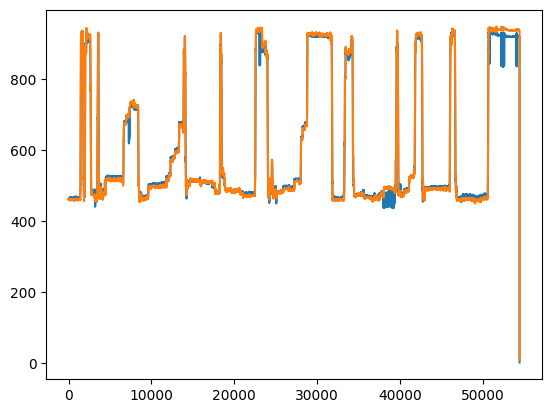

In [18]:
plt.plot(saline_dataframes[0]['center_x'])
plt.plot(saline_dataframes[0]['centerofMass']['x'])

## Step 4: Calculate Euclidean Distance from Reference Point

In [34]:
def calculate_euclidean_distance(df):
    distance_df = pd.DataFrame()
    body_parts = [col for col in df.columns.get_level_values(0).unique() if col not in ['bodyparts', 'likelihood']]
    for body_part in body_parts:
        x = df[(body_part, 'x')]
        y = df[(body_part, 'y')]
        distance = np.sqrt(x**2 + y**2)
        distance_df[body_part] = distance
    return distance_df

saline_data_distance = [calculate_euclidean_distance(df) for df in saline_dataframes]
pfa_data_distance = [calculate_euclidean_distance(df) for df in pfa_dataframes]

In [45]:
saline_data_distance[1].shape

(56312, 12)

## Step 5: Apply PCA for Dimensionality Reduction (Optional, but can speed up t-SNE)

In [49]:
all_data_distance = pd.concat([pd.concat(saline_data_distance), pd.concat(pfa_data_distance)], axis=0)

# Ensure n_components is less than or equal to min(n_samples, n_features)
# n_components = min(50, all_data_distance.shape[0], all_data_distance.shape[1])
n_components = 2

pca = PCA(n_components=n_components)  
data_pca = pca.fit_transform(all_data_distance)


(511209, 2)


<function matplotlib.pyplot.show(close=None, block=None)>

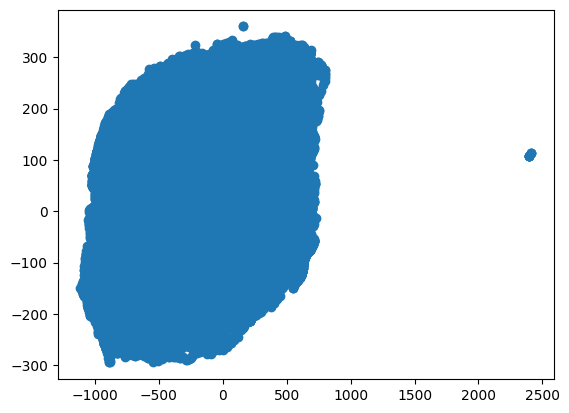

In [53]:
print(np.shape(data_pca))
plt.scatter(data_pca[:,0], data_pca[:,1])
plt.show

## Step 6: Apply t-SNE for Visualization

In [54]:
tsne = TSNE(n_components=2, perplexity=200)
data_tsne = tsne.fit_transform(all_data_distance)

plt.figure(figsize=(10, 6))
plt.scatter(data_tsne[:len(pd.concat(saline_data_distance)), 0], 
            data_tsne[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_tsne[len(pd.concat(saline_data_distance)):, 0], 
            data_tsne[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='upper right')
plt.title('t-SNE Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()


KeyboardInterrupt: 

## Step 7: Apply UMAP for Visualization

In [29]:
reducer = umap.UMAP(random_state=42)
data_umap = reducer.fit_transform(data_pca)

plt.figure(figsize=(10, 6))
plt.scatter(data_umap[:len(pd.concat(saline_data_distance)), 0], 
            data_umap[:len(pd.concat(saline_data_distance)), 1], 
            marker='o', color='red', alpha=0.7, label='saline')
plt.scatter(data_umap[len(pd.concat(saline_data_distance)):, 0], 
            data_umap[len(pd.concat(saline_data_distance)):, 1], 
            marker='s', color='blue', alpha=0.7, label='pfa')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(loc='upper right')
plt.title('UMAP Visualization of Euclidean Distance Representation')
plt.grid(True)
plt.show()

C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\huang\AppData\Local\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 